# Using FACE to get feature attributions in Regression

## Tabular regression problem - Delta Elevators dataset

### This notebook presents the use of FACE to obtain feature attributions from a trained feedforward neural network for a sample.

## Load general libraries

In [1]:
# -*- coding: utf-8 -*-

"""
Jose L. Carles - Enrique Carmona - UNED - 2024-2025
"""

#!git clone https://github.com/CarlesBou/mlpxai.git
#!cd mlpxai/src/examples/notebooks

'''
Adjust import paths if needed
'''
import os
import sys

#print(os.getcwd())

sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.insert(0, os.path.dirname(os.getcwd()))

#sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

In [2]:
'''
Import general libraries
'''
import keras
from keras.models import Model

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load FACE module from mlpxai library

In [3]:
from mlpxai.explainers.face.kerasface import FACEExplainer       # Key funtion to perform FACE feature attribution computation
from mlpxai.utils.visualize import plot_bar_contrib, get_str_val # Support module to displat feature attrubution bars

## Load the dataset of a tabular regression problem

In [4]:
'''
Regression tabular problem using 'Delta Elevators' dataset
'''
seed = 1
# np.seed = 1
# random.seed = 1
# tf.random.set_seed(1)
keras.utils.set_random_seed(seed)
       
ds_name = 'delta'
dataset_name = 'Delta Elevators'

delevators_df = pd.read_csv('sample_data/delta_elevators.csv', delimiter=';')

X = delevators_df.iloc[:, :-1]
y = delevators_df.iloc[:, -1].to_numpy()

feature_names = X.columns
num_inputs =  X.shape[1]
num_outputs = 1

use_saved_model_weights = True # We will try to load a pretrained model if exists

## Define the Keras network model

In [5]:
'''
Define the network model structure (2 hidden layers using ReLUs)
'''
input_layer = Input(shape=(num_inputs,))
hidden_layer = Dense(30, activation='relu')(input_layer)
hidden_layer = Dense(20, activation='relu')(hidden_layer)
hidden_layer = Dense(5, activation='relu')(hidden_layer)
output_layer = Dense(num_outputs, activation='linear')(hidden_layer)

test_size = 0.20
validation_split = 0.1 
epochs = 60

'''
Scale the input in range [0, 1]
'''
scaler = MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

'''
Split the dataset in train/test sets
'''
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    shuffle=True,
                                                    random_state=33
                                                    )

X_test = X_test.to_numpy()

## Compile and train the model using the training dataset

In [6]:
'''
Define and compile the Keras model
'''
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='nadam', loss='mean_squared_error')

'''
As the Delta Elevators dataset takes some time to be compiled,
we save the model as soon it is compiled for the first time to avoid
long time waiting.
'''
weights_file_name = f'{ds_name}_regression_seed_{seed}_epochs_{epochs}.weights.h5'

if use_saved_model_weights:
    if os.path.isfile(weights_file_name):
        model.load_weights(weights_file_name)
        print(f'Using pretrained regression model weights from file {weights_file_name}')
    else:
        print('Training regression model ... ', end='')
        my_fit = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, verbose=0)
        model.save_weights(weights_file_name)
        print('OK')
else:
    print(f'Using dataset: {dataset_name}, {len(y)} samples, {num_inputs} features, {num_outputs} output, ({len(y_train)} train / {len(y_test)} test)')
    print('Training regression model ... ', end='')
    my_fit = model.fit(X_train, y_train, epochs=epochs, validation_split=validation_split, verbose=0)
    print('OK')

Using pretrained regression model weights from file delta_regression_seed_1_epochs_60.weights.h5


## Run a model prediction over the test set to show the performance of the model

In [7]:
print('\nGenerating predictions over test data with MLP ... ', end='')

mlp_predictions = model.predict(X_test, verbose=0)

print('OK')

rmse = np.sqrt(metrics.mean_squared_error(y_test, mlp_predictions))

print(f'MLP results for test data RMSE = {rmse:.5f}')


Generating predictions over test data with MLP ... OK
MLP results for test data RMSE = 0.00188


## Perform the feature attribution computation using FACE

In [8]:
'''
Select a sample
'''
sample = 499

'''
Create the FACE Explainer
'''
face = FACEExplainer(model)

'''
We compute the feature attributions for the sample only needing
two parameters: the sample and the model to be analyzed
'''
face_contrib, = face.explain(X_test[sample])

print(f'FACE attributions for sample {sample}')
print(f'  Attributions: {face_contrib}')

FACE attributions for sample 499
  Attributions: [-0.01205894  0.00285782  0.00048211  0.00144897  0.00070029  0.00629325
 -0.00168449]


## Display the computed attributions in a bar plot


Plotting FACE regression feature relevance for sample 499


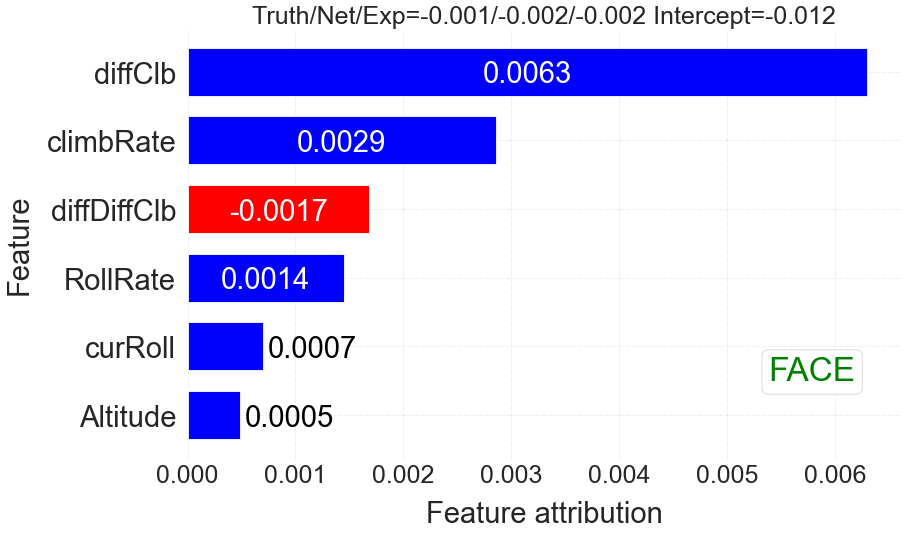

OK


In [9]:
'''
Plot feature attributions for the sample
  - The plot title contains information about the ground truth, the network prediction, 
    and FACE's prediction (Truth/Net/Exp). It also shows the intercept.
  - Each feature is displayed with a bar and the computed attribution is shown in blue 
    for positive values and in red for negative ones.
'''
print(f'\nPlotting FACE regression feature relevance for sample {sample}')

y_mlp = mlp_predictions[sample][0]
y_mlp_screen = get_str_val(y_mlp)

y_face = np.sum(face_contrib)
y_face_screen = get_str_val(y_face)

plot_bar_contrib('regression', feature_names, face_contrib, 
  title=f'Truth/Net/Exp={y_test[sample]:.03f}/{y_mlp_screen}/{y_face_screen} Intercept={face_contrib[0]:.03f}',
  legend='FACE',
  add_xlabel=True,
  resize=0.6)

print('OK')